# Text Analysis
## importing libraries

In [1]:
import ast
import pandas as pd
import numpy as np
import nltk
import pickle
import pyLDAvis.sklearn
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns

## Reading scrapped data

In [2]:
df = pd.read_csv('indeed_scrape_clean.csv')

## Correcting data types

In [3]:
df.lemmatized = [ast.literal_eval(i) for i in df.lemmatized.to_list()]

## Looking data

In [4]:
df = df[['rating', 'lemmatized']]
df.head()

,rating,lemmatized
0,5.0,"[google, culture, see, company, organizations,..."
1,2.0,"[team, work, structure, people, poor, work, ex..."
2,4.0,"[fun, place, work, industry, complex, dependin..."
3,5.0,"[definitely, great, place, work, load, activit..."
4,1.0,"[bad, local, management, worth, act, like, org..."


## converting to string

In [5]:
df['lemma_str'] = [' '.join(map(str, l)) for l in df['lemmatized']]
df.head()

,rating,lemmatized,lemma_str
0,5.0,"[google, culture, see, company, organizations,...",google culture see company organizations compl...
1,2.0,"[team, work, structure, people, poor, work, ex...",team work structure people poor work experienc...
2,4.0,"[fun, place, work, industry, complex, dependin...",fun place work industry complex depending mana...
3,5.0,"[definitely, great, place, work, load, activit...",definitely great place work load activity keep...
4,1.0,"[bad, local, management, worth, act, like, org...",bad local management worth act like organizati...


## Finding Sentiment

In [6]:
df['sentiment'] = df['lemma_str'].apply(lambda x: TextBlob(x).sentiment.polarity)
df.head()

,rating,lemmatized,lemma_str,sentiment
0,5.0,"[google, culture, see, company, organizations,...",google culture see company organizations compl...,0.100000
1,2.0,"[team, work, structure, people, poor, work, ex...",team work structure people poor work experienc...,-0.200000
2,4.0,"[fun, place, work, industry, complex, dependin...",fun place work industry complex depending mana...,0.000000
3,5.0,"[definitely, great, place, work, load, activit...",definitely great place work load activity keep...,0.515000
4,1.0,"[bad, local, management, worth, act, like, org...",bad local management worth act like organizati...,-0.128571


## Plotting sentiment distribution

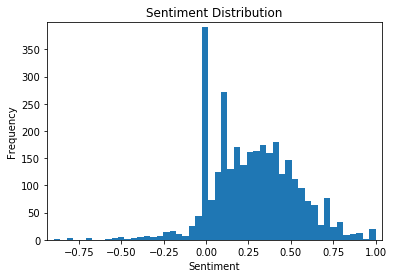

In [7]:
plt.margins(0.02)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.hist(df['sentiment'], bins=50)
plt.title('Sentiment Distribution')
plt.show()

## Noting the Ratings

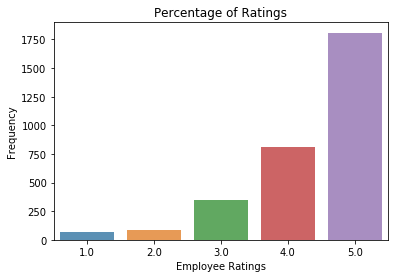

In [8]:
x_rating = df.rating.value_counts()
y_rating = x_rating.sort_index()

sns.barplot(x_rating.index, x_rating.values, alpha=0.8)
plt.title("Rating Distribution")
plt.ylabel('Frequency')

plt.xlabel('Employee Ratings')
plt.title('Percentage of Ratings')
plt.show()

## Plotting pie chart

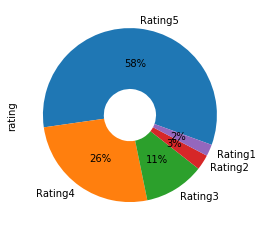

In [9]:
df.rating.value_counts().plot(kind='pie', labels=['Rating5', 'Rating4', 'Rating3', 'Rating2', 'Rating1'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20)
plt.show()

## Average sentiment per Rating

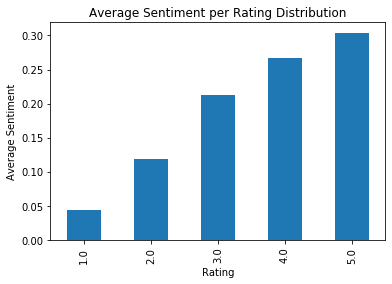

In [10]:
polarity_avg = df.groupby('rating')['sentiment'].mean().plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment per Rating Distribution')
plt.show()

## Length of words used per Rating

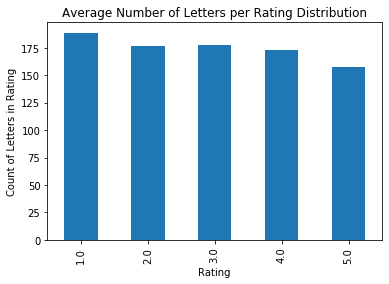

In [11]:
df['word_count'] = df['lemmatized'].apply(lambda x: len(str(x).split()))
df['review_len'] = df['lemma_str'].astype(str).apply(len)

letter_avg = df.groupby('rating')['review_len'].mean().plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Count of Letters in Rating')

plt.title('Average Number of Letters per Rating Distribution')
plt.show()

## Finding correlation

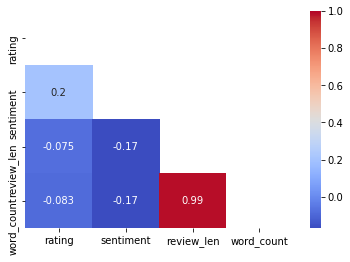

In [12]:
correlation = df[['rating','sentiment', 'review_len', 'word_count']].corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(correlation, cmap='coolwarm', annot=True, mask=mask)


## Looking at words

In [13]:
words = df['lemmatized']
allwords = []
for wordlist in words:
    allwords += wordlist
allwords

['google',
 'culture',
 'see',
 'company',
 'organizations',
 'completely',
 'different',
 'google',
 'basic',
 'idea',
 'work',
 'google',
 'collaborative',
 'nature',
 'meaning',
 'share',
 'learn',
 'learn',
 'others',
 'share',
 'overall',
 'experience',
 'google',
 'really',
 'reward',
 'fun',
 'team',
 'work',
 'structure',
 'people',
 'poor',
 'work',
 'experience',
 'especially',
 'head',
 'team',
 'lead',
 'poc',
 "'s",
 'non-professional',
 'overall',
 'management',
 'poorly',
 'operate',
 'fun',
 'place',
 'work',
 'industry',
 'complex',
 'depending',
 'manager',
 'utilize',
 'coworkers',
 'take',
 'e-learn',
 'learn',
 'definitely',
 'great',
 'place',
 'work',
 'load',
 'activity',
 'keep',
 'moral',
 'culture',
 'amazing',
 'staff',
 'great',
 'work',
 'everyone',
 'meat',
 'friendly',
 'helpful',
 'every',
 'way',
 'bad',
 'local',
 'management',
 'worth',
 'act',
 'like',
 'organization..',
 'supress',
 'insult',
 'dominate',
 'subordinates..',
 'manager',
 'worth',
 '

## making word cloud

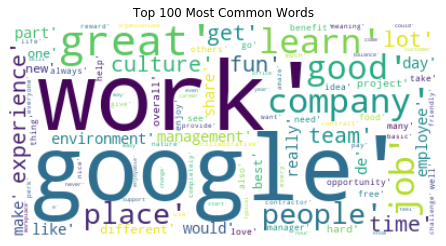

In [14]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(background_color='white').generate(str(mostcommon))
fig = plt.figure(facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words')
plt.tight_layout(pad=0)
plt.show()

## Studying Frequency of words

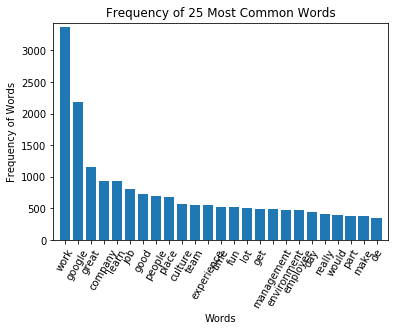

In [15]:
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)

plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words')
plt.ylabel('Frequency of Words')

plt.xticks(rotation=60)
plt.title('Frequency of 25 Most Common Words')
plt.show()


## Analyzing Word frequency for Rating = 1

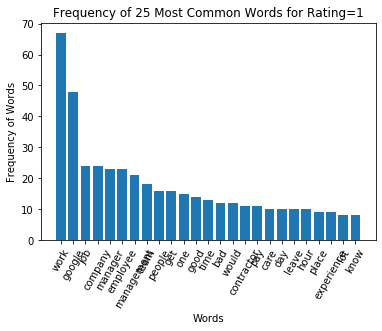

In [16]:
group_by = df.groupby('rating')['lemma_str'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_0 = group_by.iloc[0]
words0 = list(zip(*group_by_0))[0]
freq0 = list(zip(*group_by_0))[1]

plt.bar(words0, freq0)
plt.xlabel('Words')
plt.ylabel('Frequency of Words')

plt.xticks(rotation=60)
plt.title('Frequency of 25 Most Common Words for Rating=1')
plt.show()

## Analyzing Word frequency for Rating = 2

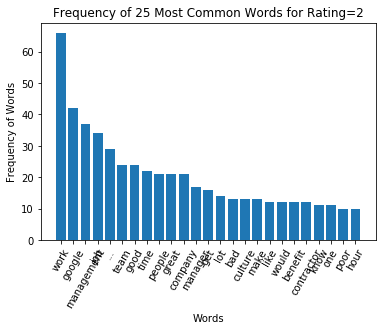

In [17]:
group_by_1 = group_by.iloc[1]
words1 = list(zip(*group_by_1))[0]
freq1 = list(zip(*group_by_1))[1]

plt.bar(words1, freq1)
plt.xlabel('Words')
plt.ylabel('Frequency of Words')

plt.xticks(rotation=60)
plt.title('Frequency of 25 Most Common Words for Rating=2')
plt.show()

## Analyzing Word frequency for Rating = 3

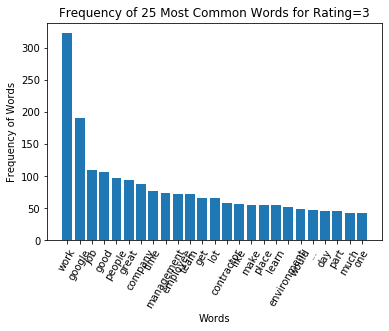

In [18]:
group_by_2 = group_by.iloc[2]
words2 = list(zip(*group_by_2))[0]
freq2 = list(zip(*group_by_2))[1]

plt.bar(words2, freq2)
plt.xlabel('Words')
plt.ylabel('Frequency of Words')

plt.xticks(rotation=60)
plt.title('Frequency of 25 Most Common Words for Rating=3')
plt.show()

## Analyzing Word frequency for Rating = 4

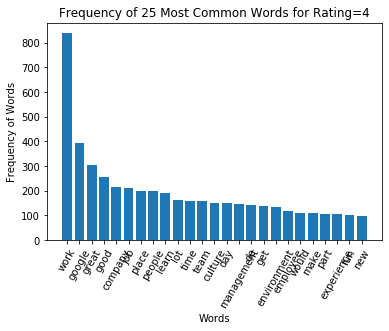

In [19]:
group_by_3 = group_by.iloc[3]
words3 = list(zip(*group_by_3))[0]
freq3 = list(zip(*group_by_3))[1]

plt.bar(words3, freq3)
plt.xlabel('Words')
plt.ylabel('Frequency of Words')

plt.xticks(rotation=60)
plt.title('Frequency of 25 Most Common Words for Rating=4')
plt.show()

## Analyzing Word frequency for Rating = 5

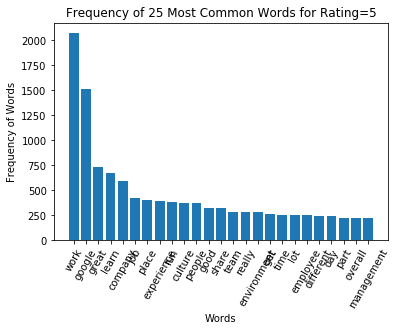

In [20]:
group_by_4 = group_by.iloc[4]
words4 = list(zip(*group_by_4))[0]
freq4 = list(zip(*group_by_4))[1]
plt.bar(words4, freq4)
plt.xlabel('Words')
plt.ylabel('Frequency of Words')
plt.xticks(rotation=60)
plt.title('Frequency of 25 Most Common Words for Rating=5')
plt.show()